In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
mpl.rcParams['figure.figsize'] = [12,8]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CZ4041 Machine Learning Project/Colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1ldppAeVJfaoI4cvwZyTCju9jXbD4LI-H/CZ4041 Machine Learning Project/Colab


In [ ]:
def expand_df(df):
    data = df.copy()
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofweek'] = data.index.dayofweek
    data['dayofyear']=data.index.dayofyear
    data['weekofyear']=data.index.weekofyear
    return data

In [ ]:
data=pd.read_csv('data/train.csv',parse_dates=['date'],index_col=['date'])
data=expand_df(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [ ]:
data.describe()

,store,item,sales,day,month,year,dayofweek,dayofyear,weekofyear
count,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287,15.727820,6.523549,2015.000548,3.001643,183.100219,26.615553
std,2.872283,14.430878,28.801144,8.799329,3.448535,1.414021,1.999316,105.424201,15.060967
min,1.000000,1.000000,0.000000,1.000000,1.000000,2013.000000,0.000000,1.000000,1.000000
25%,3.000000,13.000000,30.000000,8.000000,4.000000,2014.000000,1.000000,92.000000,14.000000
50%,5.500000,25.500000,47.000000,16.000000,7.000000,2015.000000,3.000000,183.000000,27.000000
75%,8.000000,38.000000,70.000000,23.000000,10.000000,2016.000000,5.000000,274.000000,40.000000
max,10.000000,50.000000,231.000000,31.000000,12.000000,2017.000000,6.000000,366.000000,53.000000


Sales distribution is skewed to the right

In [ ]:
print('mean sales {}'.format(data['sales'].mean()))
print('median sales {}'.format(data['sales'].median()))
print('mode sales {}'.format(data['sales'].mode()[0]))

mean sales 52.250286966046005
median sales 47.0
mode sales 30


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


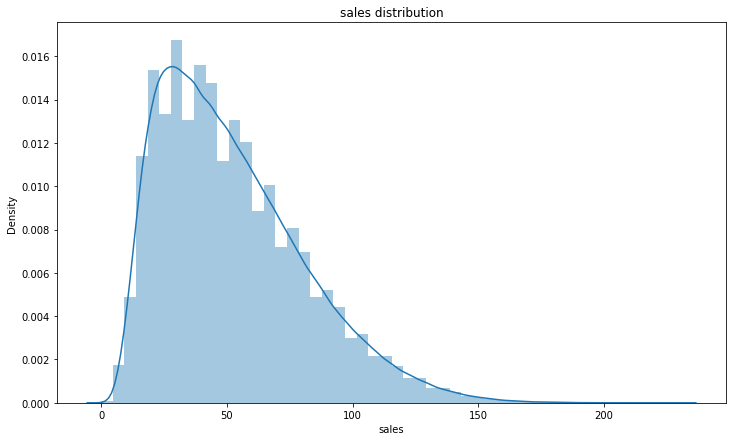

In [ ]:
sb.distplot(data['sales'])
plt.title('sales distribution')
plt.show()

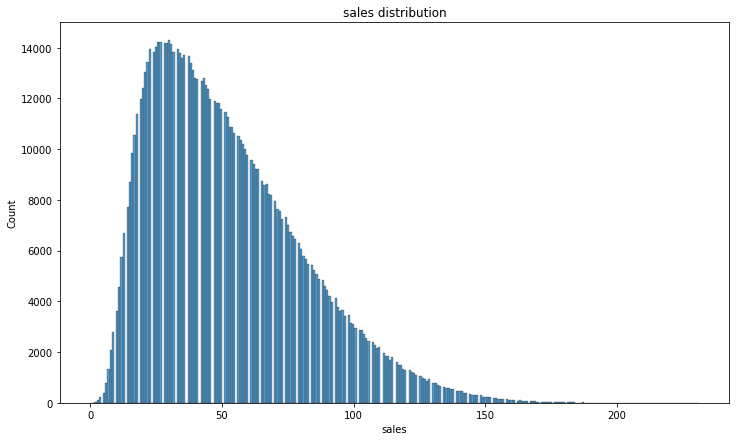

In [ ]:
sb.histplot(x='sales',data=data)
plt.title('sales distribution')
plt.show()

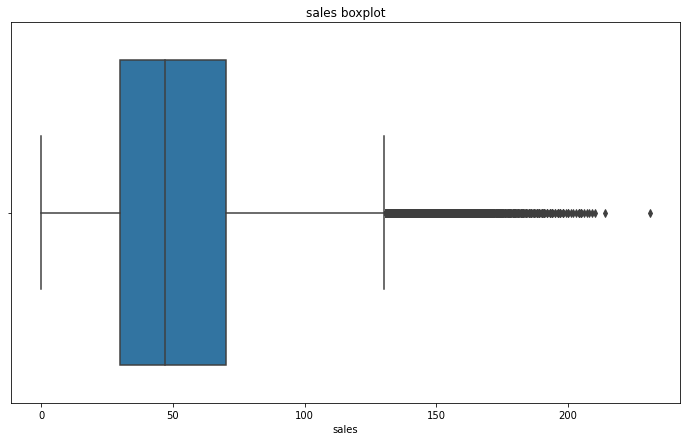

In [ ]:
sb.boxplot(x=data['sales'])
plt.title('sales boxplot')
plt.show()

In [ ]:
len(data[data['sales'] > 200] )/ len(data['store'] == 2) * 100 

0.0017524644030668128

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


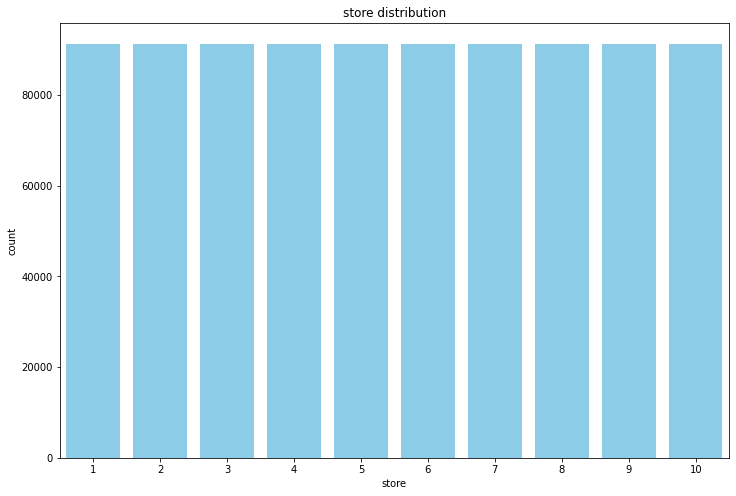

In [ ]:
sb.countplot(data['store'],color='skyblue',saturation=0.9)
plt.title('store distribution')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


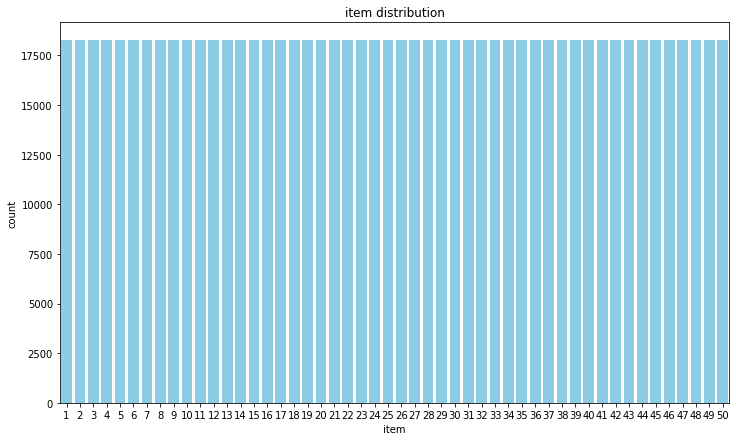

In [ ]:
mpl.rcParams['figure.figsize'] = [12,7]
sb.countplot(data['item'],color='skyblue',saturation=0.9)
plt.title('item distribution')
plt.show()

sales over 200 seem abnormal and are more promintent for the second store with a random pattern. We classifiy these as outliers and remove them from the dataset

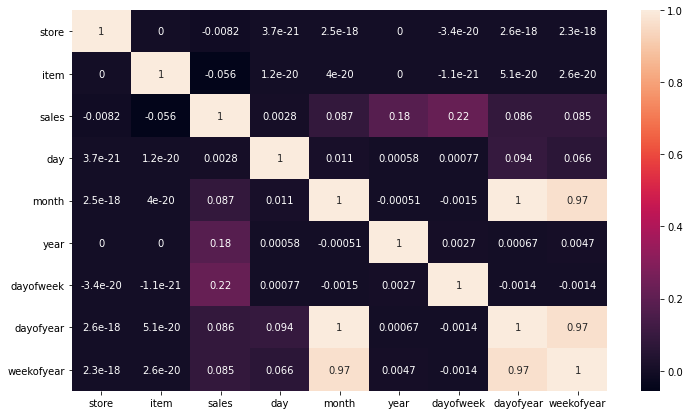

In [ ]:
sb.heatmap(data.corr(),annot=True)

# Proof of synthetic data

In [ ]:
df_train_norm = data.copy()

"""
The transform function creates the dataframe of the same shape as the original data with the aggrgation method applied to each record. For example
all items 1 sales of store 1 will be divided by a particular number and so on
"""

df_train_norm['sales'] /= data.groupby(['item', 'store'])['sales'].transform('mean')

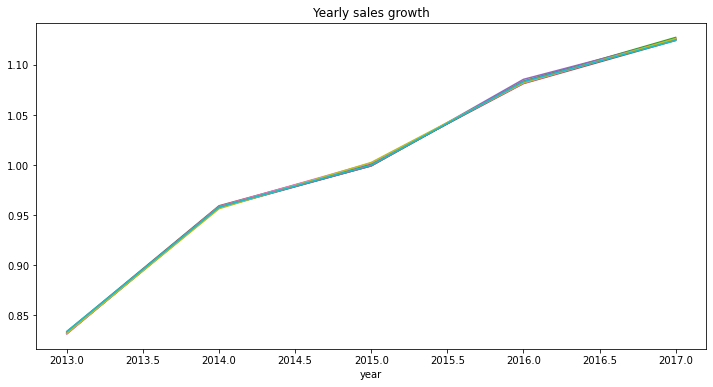

In [ ]:
mpl.rcParams['figure.figsize'] = [12,6]
df_train_norm.groupby(['store', 'year'])['sales'].mean().unstack(['store']).plot(title='Yearly sales growth', legend=False)

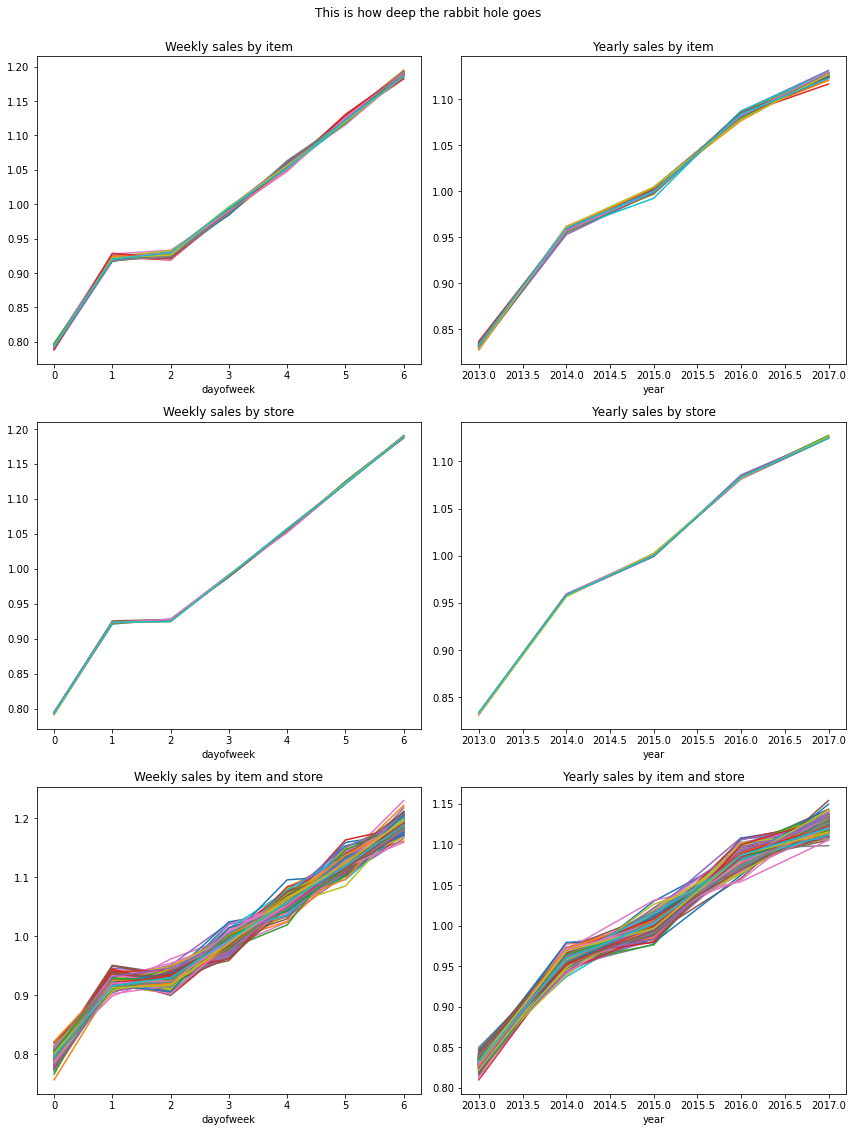

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 16))
_ = df_train_norm.groupby(['item', 'dayofweek'])['sales'].mean().unstack('item').plot(title='Weekly sales by item', legend=False, ax=ax[0,0])
_ = df_train_norm.groupby(['store', 'dayofweek'])['sales'].mean().unstack('store').plot(title='Weekly sales by store', legend=False, ax=ax[1,0])
_ = df_train_norm.groupby(['item', 'store', 'dayofweek'])['sales'].mean().unstack(['item', 'store']).plot(title='Weekly sales by item and store', legend=False, ax=ax[2,0])
_ = df_train_norm.groupby(['item', 'year'])['sales'].mean().unstack('item').plot(title='Yearly sales by item', legend=False, ax=ax[0,1])
_ = df_train_norm.groupby(['store', 'year'])['sales'].mean().unstack('store').plot(title='Yearly sales by store', legend=False, ax=ax[1,1])
_ = df_train_norm.groupby(['item', 'store', 'year'])['sales'].mean().unstack(['item', 'store']).plot(title='Yearly sales by item and store', legend=False, ax=ax[2,1])
fig.suptitle('This is how deep the rabbit hole goes')
fig.tight_layout(rect=[0, 0, 1, 0.96])

Visually, shapes of sales volume time series across all items and stores look suspiciously regular and similar to each other;
Weekly and yearly seasonal patterns are very stable for every store-item combination, and trend is relatively stable too;
Consistency between time series level and standard deviation indicates unusual regularity in time series noise component;

# Yearly Trend calculation

In [ ]:
agg_yearTable= pd.pivot_table(data, index='year', values='sales', aggfunc=np.mean) / data['sales'].mean()

In [ ]:
years = np.arange(2013, 2019)
annual_growth = agg_yearTable.values.squeeze()

exponentialDecay = np.exp((years - 2018)/6)

LinearyearFactor = np.poly1d(np.polyfit(years[:-1], annual_growth, 1, w=exponentialDecay[:-1]))
QuadraticyearFactor = np.poly1d(np.polyfit(years[:-1], annual_growth, 2, w=exponentialDecay[:-1]))
CubicyearFactor = np.poly1d(np.polyfit(years[:-1], annual_growth, 3, w=exponentialDecay[:-1]))

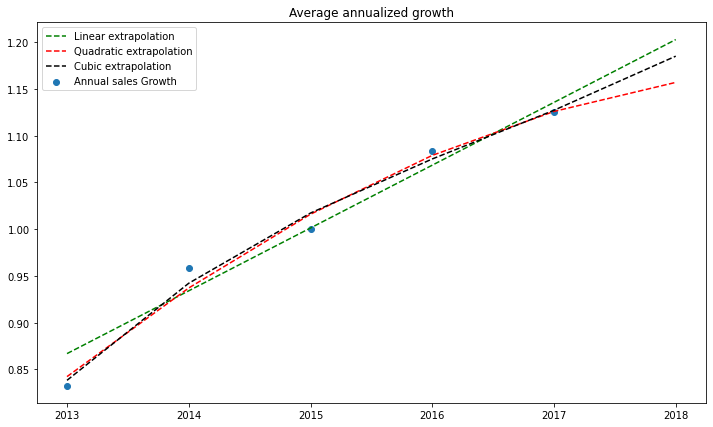

In [ ]:
plt.scatter(agg_yearTable.index,agg_yearTable['sales'],label='Annual sales Growth')
plt.plot(years, LinearyearFactor(years), '--', label='Linear extrapolation',c='g')
plt.plot(years, QuadraticyearFactor(years), '--', label='Quadratic extrapolation',c='r')
plt.plot(years, CubicyearFactor(years), '--', label='Cubic extrapolation',c='black')
plt.title('Average annualized growth')
plt.legend()
plt.show()

Average annualized growth follows a linear trend